In [1]:
import pandas as pd

In [41]:
# load the data

In [2]:
df = pd.read_excel('cleaned_message_content.xlsx')

In [3]:
df.head()

,author,messagecontent
0,Churchill,great product high beams high precisely diverg...
1,JB 911,may ideal setup wire lows stay highs would help
2,Churchill,morimoto already allow low beams stay highs pr...
3,Chuck W.,help issue sorry call retrofit customer servic...
4,k722070,maybe one orange spacers wrong spot


In [4]:
# df.drop(['id', 'date', 'order', 'author_url', 'thread_id', 'thread_url'],  axis=1, inplace=True)

In [5]:
df.shape

(451672, 2)

In [6]:
df.dropna(subset = ['messagecontent'], inplace=True)

In [42]:
# cleaning the data

In [7]:
import re
import string
from nltk.corpus import stopwords

In [9]:
def clean_text(text):
    text = text.replace('\\n', ' ').replace('\n', ' ')
    text = text.lower()
    text = re.sub('[\W]+', ' ', text, flags=re.UNICODE)
    text = re.sub(r'\b\w{1,2}\b', ' ', text).strip()
    text = re.sub('['+string.punctuation+']', ' ', text)
    text = re.sub(r"\s+"," ", text, flags = re.UNICODE)
    text = text.split()
    stops = set(stopwords.words('english'))
    text = [w for w in text if not w in stops and len(w) >= 2]
    text = ' '.join(text)
    text = re.sub(r"\s+"," ", text, flags = re.UNICODE)
    text = text.strip()
    return text

In [10]:
# df['messagecontent'] = df['messagecontent'].map(str).map(lambda line: clean_text(line))

In [43]:
# count word frequency in each row

In [12]:
def calculate_no_of_words_in_a_sentence(sentence):
    split_sentence = sentence.split()
    no_words = len(split_sentence)
    return no_words

In [14]:
df['word_count'] = df['messagecontent'].map(lambda line: calculate_no_of_words_in_a_sentence(line))
# test_df['word_count'] = test_df['messagecontent'].str.split().map(len)

In [15]:
df.head()

,author,messagecontent,word_count
0,Churchill,great product high beams high precisely diverg...,66
1,JB 911,may ideal setup wire lows stay highs would help,9
2,Churchill,morimoto already allow low beams stay highs pr...,42
3,Chuck W.,help issue sorry call retrofit customer servic...,25
4,k722070,maybe one orange spacers wrong spot,6


In [16]:
df = df.sort_values('word_count', ascending=False) 

In [17]:
df = df.reset_index(drop=True)

In [18]:
df.head()

,author,messagecontent,word_count
0,Chuck W.,updated 2018 build date user 1994 sep 0178 911...,1293
1,CamsPorsche,1994 sep 0178 911te 1994 2025 mvtm 1994 x473 y...,1289
2,Paul M,updated list build date user 1994 sep 0178 911...,1244
3,Chuck W.,updated list build date user 1994 sep 0178 911...,1244
4,jg291446,updated list build date user 1994 sep 0178 911...,1243


In [19]:
df['word_count'].min(), df['word_count'].max(), df['word_count'].mean(), df['word_count'].std()

(1, 1293, 23.025890943193996, 33.86267581577216)

In [20]:
df = df[df['word_count']>10].reset_index(drop=True)

In [21]:
df.shape

(257713, 3)

In [44]:
# select top 50k  rows based on word count in each row

In [22]:
df_reduced = df[:50000]

In [23]:
text_description = df_reduced['messagecontent'].tolist()

In [24]:
len(text_description)

50000

In [45]:
# visualize words in description using word cloud

In [26]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
from wordcloud import WordCloud, STOPWORDS

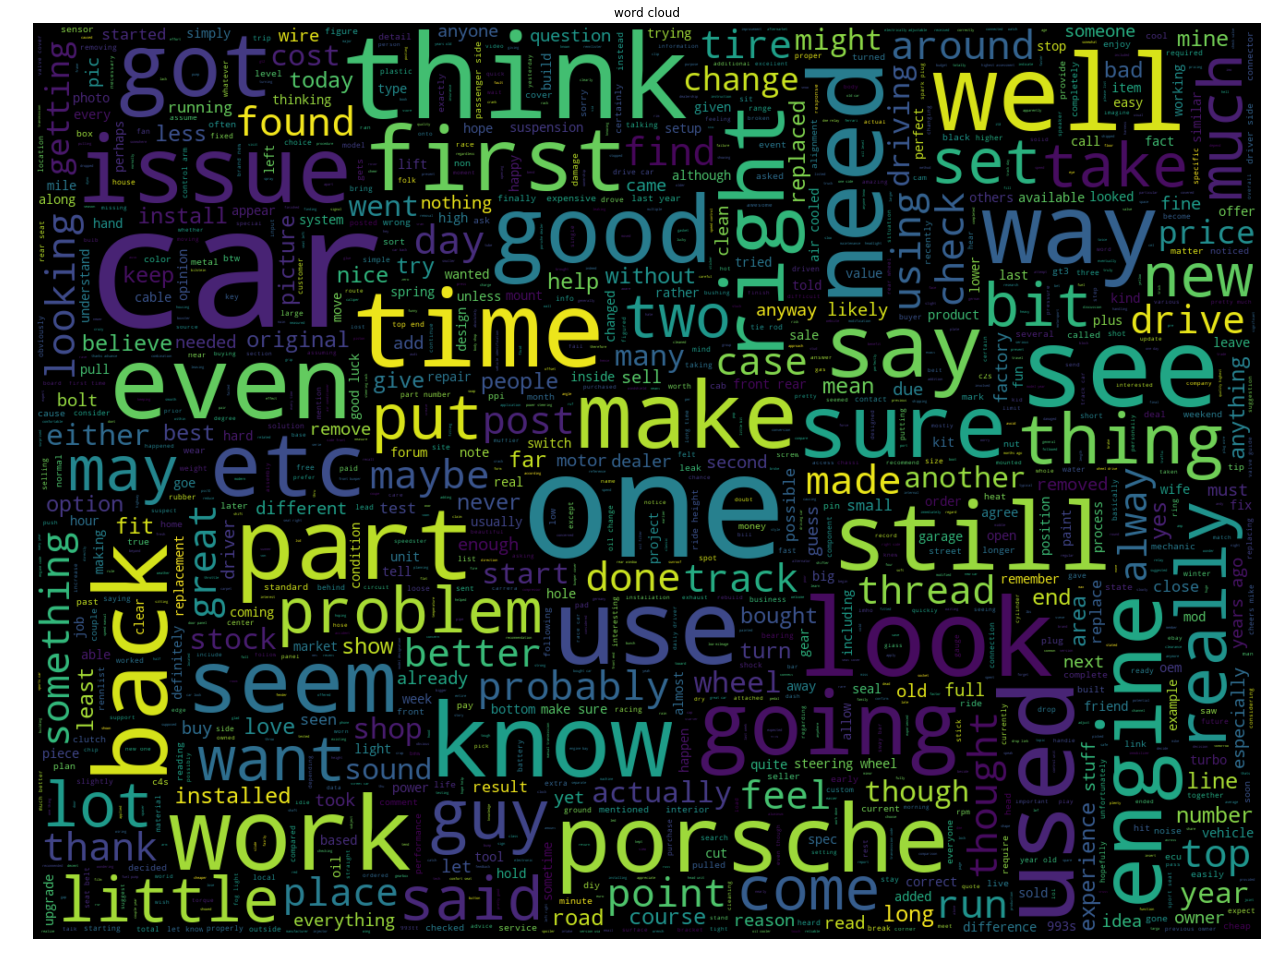

In [27]:
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)


mask = np.array(Image.open("parrot.png"))
stopwords = set(STOPWORDS)
word_string = ','.join(list(df_reduced['messagecontent'].values))
wc = WordCloud(max_words=10000, mask=mask, stopwords=stopwords, margin=10, random_state=1).generate(word_string)
default_colors = wc.to_array()
plt.figure(figsize=(22, 20))
plt.title("word cloud")
plt.imshow(default_colors, interpolation="bilinear")
plt.axis("off")
plt.show()

In [28]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [29]:
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
count = vectorizer.fit_transform(text_description)
tf_feature_names = vectorizer.get_feature_names()

In [46]:
# top 10 frequent words

In [33]:
import seaborn as sns
sns.set_style('whitegrid')

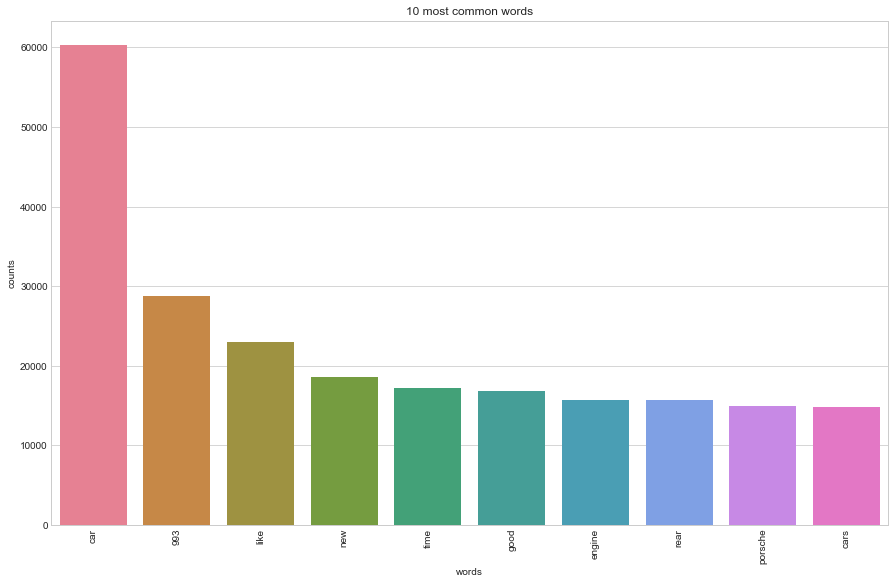

In [35]:
def plot_10_most_common_words(count_data, count_vectorizer):
    
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

plot_10_most_common_words(count, vectorizer)

In [47]:
# topic modeling using lda

In [37]:
no_topics = 10
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(count)

In [38]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
engine oil car air valve light clutch check battery problem
Topic 1:
car like time good new thanks know got work shop
Topic 2:
black blue red silver color green white grey yellow metallic
Topic 3:
porsche car price miles 993 000 dealer owner condition coupe
Topic 4:
oil day drive porsche great trip event road time cars
Topic 5:
car 993 cars like think good drive years really track
Topic 6:
rear wheels wheel 993 set stock suspension tires new car
Topic 7:
door unit radio speakers sound amp hifi set battery speaker
Topic 8:
remove use used plastic rear need bolts bolt cover seal
Topic 9:
seat seats leather rear airbag wheel steering fog version control


In [67]:
import os
from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

if 1 == 1:
    LDAvis_prepared = sklearn_lda.prepare(lda, count, vectorizer)
    with open('ldavis_prepared_'+str(no_topics)+'.pickle', 'wb') as handle:
        pickle.dump(LDAvis_prepared, handle, protocol=pickle.HIGHEST_PROTOCOL)

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


In [66]:
with open('ldavis_prepared_10.pickle', 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, 'ldavis_prepared_'+ str(no_topics) +'.html')